In [2]:
import clickhouse_connect
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

Use the following command to get the IP Address of the docker container running the database, and then
use that for the host argument below:
docker inspect -f '{{range.NetworkSettings.Networks}}{{.IPAddress}}{{end}}' database

# Tables Loaded in Clickhouse:

1. **cps_00004** - an extract of the IPUMS Current Population Survery dataset
        source: https://cps.ipums.org/cps/
        
2. **rural_urban_codes** - A table that allows each county to be classified as metro/non-metro and a range of population within the county
        source: https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx
        
3. **income_tax** - A per-county dataset that relates Adjusted Gross Income, taxes paid and number of tax returns. The columns here are a subset of the columns of the whole dataset, but many columns are available that include different income sources, family dependents, and much much more. The current dataset is only from 2015, but the schemas for more recent years should be similar and can be loaded in when needed.
        source: https://www.irs.gov/statistics/soi-tax-stats-county-data-2015
        
4. **life_expectancy** - Table provides life expectancy down to the level of census tract
        source: https://catalog.data.gov/dataset/u-s-life-expectancy-at-birth-by-state-and-census-tract-2010-2015
        
5. **places_county** - per-county data that provides prevalence of various health outcomes and behavioral risk factors for 2023. The same datasource also provides census tract-level data and provides data in GeoJSON format, but neither has been uploaded to the database thus far.
        source: https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/swc5-untb/about_data

# Table Schemas
For reference, here are the schema definitions for all of the above tables:

Note: For `COUNTY`, there are about 2 MM rows with county provided, but most rows have COUNTY = 0. 
However, all of those rows that have COUNTY = 0 instead provide METROAREA to identify geographic location. 
There are two options to deal with this:
1. Work with the dataset as two groups, one based on county and one based on metro area. Each individually should provide significant amounts of data.
2. The rows that provide METAREA also provide METFIPS, and if we had a dataset linking counties to metro areas, we can map all the counties to metro areas. It's possible to try and map all the metro areas to a county, but metro areas sometimes span multiple counties; we could still go from metro -> counties if we're willing to throw away metros that span multiple counties, but that would remove metro areas like New York and Philadelphia.

Source (account required): https://cps.ipums.org/cps/ 
```sql
CREATE TABLE cps_00004 (
    ROWNUM              UInt32 PRIMARY KEY,
    YEAR                UInt16,
    SERIAL              UInt64,
    MONTH               Nullable(UInt8),
    MONTH_NAME          Nullable(String),
    CPSID               Nullable(UInt64),
    ASECFLAG            Nullable(UInt8),
    HFLAG               Nullable(UInt8),
    ASECWTH             Nullable(Decimal(10, 4)),
    STATEFIP            UInt8,
    STATEFIP_NAME       String,
    STATECENSUS         Nullable(UInt8),
    COUNTY              Nullable(UInt32),
    METFIPS             UInt32,
    METAREA             UInt16,
    METAREA_NAME        String,
    METRO               UInt8,
    METRO_NAME          String,
    INDIVIDCC           Nullable(UInt8),
    PERNUM              UInt8,
    CPSIDV              Nullable(UInt64),
    CPSIDP              Nullable(UInt64),
    ASECWT              Nullable(Decimal(10, 4)),
    EDUC                UInt16,
    EDUC_NAME           String,
    HIGRADE             UInt16,
    HIGRADE_NAME        String,
    FTOTVAL             Nullable(Int64),
    INCTOT              Int64,
    ADJGINC             Nullable(Int64),
    FEDTAX              Nullable(Int64),
    FEDTAXAC            Nullable(Int64),
    MARGTAX             Nullable(UInt8),
    STATETAX            Nullable(Int64),
    STATAXAC            Nullable(Int64),
    TAXINC              Nullable(Int32)
) ENGINE = MergeTree();
```

Selected the 2023 (most recent) dataset from the page. 
Source: https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx
```sql
CREATE TABLE rural_urban_codes (
    FIPS                    UInt64 PRIMARY KEY,
    STATE_ABBREV            String,
    COUNTY_NAME             String,
    POP                     UInt32,
    RUCC                    UInt8,
    DESCR                   String
) ENGINE = MergeTree();
```

Life expectancy by State and Census Tract. Records that have a NULL County field, but non-NULL life expectancy field should represent life expectancy across the whole state.
Unfortunately the source data did not contain a FIPS field to join this with the other dataset easily.
Source: https://catalog.data.gov/dataset/u-s-life-expectancy-at-birth-by-state-and-census-tract-2010-2015
```sql
CREATE TABLE life_expectancy (
    ROWNUM                    UInt32 PRIMARY KEY,
    STATE_NAME                String,
    COUNTY                    Nullable(String),
    CENSUS_TRACT_NUMBER       Nullable(Decimal(6, 2)),
    LIFE_EXPECTANCY           Nullable(Decimal(3, 1)),
    LIFE_EXPECTANCY_RANGE     Nullable(String),
    LIFE_EXPECTANCY_STD_ERR   Nullable(Decimal(5, 4)),
) ENGINE = MergeTree();
```

This is based on collected tax data from each county in the US in 2015 (selected to avoid abberations from COVID). This page provides the source and a downloadable description for each column in the source dataset:
https://www.irs.gov/statistics/soi-tax-stats-county-data-2015

Note about AGI_STUB:

Each county is further broken down into the number of tax returns that fall within a certain range (i.e. $50-75k, etc.). This is helpful because it provides us with a _distribution_ for the county, rather than forcing us to take the average AGI and assume it's uniform across the whole county, since that's obviously untrue. 

There are 8 AGI_STUB classes (defined in documentation at link above), so that means that each county will appear 8 times in the dataset.

Note that a set of tax returns R is included in AGI_STUB S if the value of TOTAL_AGI(R) / SIZE(R) (i.e. the average)  is within RANGE(S). So within each AGI_STUB class, we must still use an average, which has been precomputed from the original dataset and stored in columns `AVG_AGI_PER_FILE` and `AVG_TAXES_PER_FILER`.

```sql
CREATE TABLE income_tax (
    ROWNUM                    UInt32 PRIMARY KEY,
    TAX_YEAR                  UInt16,
    STATEFIPS                 UInt32,
    STATE_ABBREV              String,
    COUNTYFIP                 UInt32,
    COUNTY_NAME               String,
    AGI_STUB                  UInt8,
    NUM_RETURNS               UInt64,       -- N1
    ADJUSTED_GROSS_INCOME     Int64,        -- A00100
    TAXES_PAID_AMOUNT         Int64,        -- A18300
    TOTAL_TAX_PAYMENTS_AMOUNT Int64,        -- A10600
    AVG_AGI_PER_FILER         Int64,        -- A00100 / N1
    AVG_TAXES_PER_FILER       Int64         -- A18300 / N1
) ENGINE = MergeTree();
```

This is a another survey based dataset that asks respondents to answer questions related to health outcomes (i.e. had a tooth removed) or behavioral risk factors (i.e. tobacco use). In this dataset all the responses are given as a percentage of the population that responded YES to the survey question. The question asked is given in the MEASURE column, and the percentage of affirmative responses is given in the DATA_VALUE column. 

See this page for the source and more information:
https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/swc5-untb/about_data

```sql
CREATE TABLE places_county (
    ROWNUM                      UInt32 PRIMARY KEY,
    YEAR                        UInt16,
    STATE_ABBREV                String,
    STATE_NAME                  String,
    COUNTY_NAME                 String,
    DATASOURCE                  String,
    CATEGORY                    String,
    MEASURE                     String,
    DATA_VALUE_UNIT             String,
    DATA_VALUE_TYPE             String,
    DATA_VALUE                  Decimal(3, 1),
    DATA_VALUE_FOOTNOTE_SYMBOL  Nullable(String),
    DATA_VALUE_FOOTNOTE         Nullable(String),
    LOW_CONFIDENCE_LIMIT        Decimal(3, 1),
    HIGH_CONFIDENCE_LIMIT       Decimal(3, 1),
    TOTAL_POPULATION            UInt32,
    COUNTY_FIPS                 UInt32,
    CATEGORY_ID                 String,
    MEASURE_ID                  String,
    DATA_VALUE_TYPE_ID          String,
    SHORT_QUESTION_TEXT         String,
    GEOLOCATION                 Point
) ENGINE = MergeTree();
```




CREATE TABLE state_regions (
    STATE_FIPS UInt32 PRIMARY KEY,
    STATE_NAME String,
    STATE_ABBREV String,
    DIVISION String,
    REGION String
) ENGINE = MergeTree();

CREATE TABLE state_fips (
    STATE_FIPS UInt32 PRIMARY KEY,
    STATE_NAME String
) ENGINE = MergeTree();




The STATE_COUNTY_FIPS is a 5-digit code. First 2 digits are the state FIPS, last 3 digits are the county FIPS. 
This is the only unique identifier for counties across the whole nation since each county FIPS is numbered 0-N within
its own state.

CREATE TABLE county_fips (
    STATE_COUNTY_FIPS UInt64 PRIMARY KEY,
    COUNTY_FIPS UInt32,
    COUNTY_NAME String,
    STATE_FIPS  UInt32,
    STATE_NAME  String
) ENGINE = MergeTree();



# How to join tables:

cps_00004.YEAR must be > 1994 since the FIPS standard was introduced in 1994, so everything before should be filtered out so we don't have to deal with irregularities and alternative meanings to the FIPS fields for State or County. 

In general expect to have complex WHERE clauses for data from IPUMS/CPS since it was collected over many years across several changes in data encoding and survey fields and certain standards, so sometimes a Metro Area is provided, but no county FIPS or an incorrect county FIPS of 0 is provided in one record and the correct county FIPS is present on another record.

## cps_00004 and places_county:
    SELECT * 
    FROM cps_00004 
    JOIN places_county 
    ON cps_00004.COUNTY = places_county.COUNTY_FIPS 
    WHERE cps_00004.YEAR > 1994

## cps_00004 and income_tax:
    
    County-level: 
    
        SELECT * 
        FROM cps_00004 
        JOIN income_tax 
        ON cps_00004.COUNTY = income_tax.COUNTYFIP 
        WHERE cps_00004.YEAR > 1994;
        
    State-level: 
    
        SELECT * 
        FROM cps_00004 
        JOIN income_tax 
        ON cps_00004.STATEFIP = income_tax.STATEFIPS 
        LIMIT 10 
        WHERE cps_00004.YEAR > 1994

## cps_00004 and rural_urban_codes:

    SELECT * 
    FROM cps_00004 
    JOIN rural_urban_codes 
    ON cps_00004.COUNTY = rural_urban_codes.FIPS 
    WHERE cps_00004.YEAR > 1994
    
    A more complex example:
    
    SELECT DISTINCT COUNTY, METAREA_NAME 
    FROM cps_00004 
    WHERE 
        YEAR > 1994 
        AND 
        COUNTY IS NOT NULL 
        AND 
        COUNTY != 0 
        AND 
        METAREA_NAME IS NOT NULL 
        AND 
        METAREA_NAME != ''

## cps_00004 and life_expectancy:
    
    SELECT *
    FROM   
    (
        SELECT * 
        FROM cps_00004.county_fips
        JOIN cps_00004.cps_00004
        ON county_fips.STATE_COUNTY_FIPS = cps_00004.COUNTY
    ) as inside
    JOIN cps_00004.life_expectancy
    ON life_expectancy.STATE_NAME = inside.STATE_NAME AND life_expectancy.COUNTY = inside.COUNTY_NAME

In [3]:
# client = clickhouse_connect.get_client(host='172.20.0.2', username='default', password='Password123!')
client = clickhouse_connect.get_client(host='hub.publichealthhq.xyz', port=18123, username='default', password='Password123!')

# Income Inequality & Health Outcomes

In [8]:
# result = client.query("SELECT YEAR, MONTH, MONTH_NAME, STATEFIP, STATEFIP_NAME, COUNTY, METAREA_NAME, EDUC_NAME, HIGRADE_NAME, FTOTVAL, INCTOT FROM cps_00004.cps_00004 LIMIT 1000000")

"""SELECT places_county.COUNTY_FIPS, income_tax.COUNTY_NAME, STATE_NAME, STATE_ABBREV, AGI_STUB, ADJUSTED_GROSS_INCOME, MEASURE, DATA_VALUE  
FROM cps_00004.places_county 
JOIN cps_00004.income_tax 
ON cps_00004.places_county.COUNTY_FIPS = cps_00004.income_tax.COUNTYFIP
WHERE cps_00004.places_county.CATEGORY = 'Health Outcomes'"""

"""
SELECT avg(AGI_STUB), any(MEASURE), AVG(DATA_VALUE), median(DATA_VALUE)  
FROM cps_00004.places_county 
JOIN cps_00004.income_tax 
ON cps_00004.places_county.COUNTY_FIPS = cps_00004.income_tax.COUNTYFIP
WHERE cps_00004.places_county.CATEGORY = 'Health Outcomes'  GROUP BY places_county.COUNTY_FIPS
"""

"""
SELECT AGI_STUB, any(MEASURE), AVG(DATA_VALUE), median(DATA_VALUE)  
FROM cps_00004.places_county 
JOIN cps_00004.income_tax 
ON cps_00004.places_county.COUNTY_FIPS = cps_00004.income_tax.COUNTYFIP
WHERE cps_00004.places_county.CATEGORY = 'Health Outcomes'  GROUP BY AGI_STUB
"""

"""
SELECT (sum(ADJUSTED_GROSS_INCOME) / sum(NUM_RETURNS)) as agiavg, (sum(TAXES_PAID_AMOUNT) / sum(NUM_RETURNS)) as taxavg, any(STATE_NAME), any(COUNTY_NAME), MEASURE, avg(DATA_VALUE), median(DATA_VALUE) 
FROM cps_00004.places_county 
JOIN cps_00004.income_tax 
ON cps_00004.places_county.COUNTY_FIPS = cps_00004.income_tax.COUNTYFIP 
GROUP BY COUNTY_FIPS, MEASURE
ORDER BY agiavg DESC
"""

result = client.query(""" 
SELECT STATE_NAME, COUNTY, CENSUS_TRACT_NUMBER
FROM cps_00004.life_expectancy
LIMIT 20
""")

df = pl.from_dicts(result.named_results(), infer_schema_length=400)

In [9]:
df

STATE_NAME,COUNTY,CENSUS_TRACT_NUMBER
str,str,"decimal[*,2]"
"""﻿Alabama""",null,null
"""Alabama""","""Autauga County…",201
"""Alabama""","""Autauga County…",202
"""Alabama""","""Autauga County…",203
"""Alabama""","""Autauga County…",204
"""Alabama""","""Autauga County…",205
"""Alabama""","""Autauga County…",206
"""Alabama""","""Autauga County…",207
"""Alabama""","""Autauga County…",208.01


In [10]:
df = df.with_columns( (pl.col('avg(DATA_VALUE)') / avg_dv).alias('normalized_dv')  )

NameError: name 'avg_dv' is not defined

In [480]:
s = [ (agi, tax) for (agi, tax) in zip(df['agiavg'], df['taxavg']) ]
obvs = np.asarray(s).transpose()
np.corrcoef(obvs)

array([[1.        , 0.76912121],
       [0.76912121, 1.        ]])

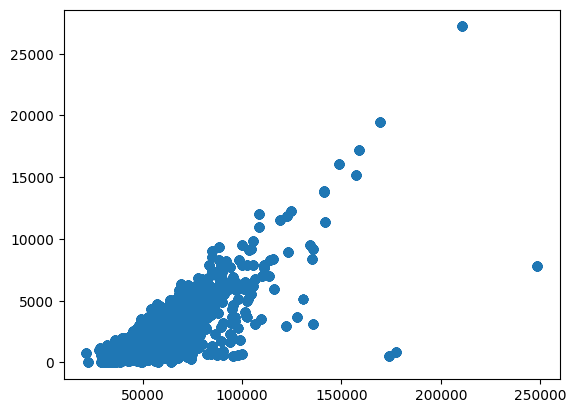

In [465]:
plt.scatter(df['agiavg'], df['taxavg'])
plt.show()

Measure: ('Chronic obstructive pulmonary disease among adults aged >=18 years',)


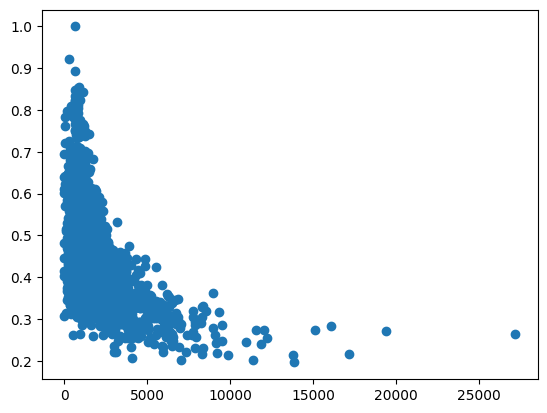

Measure: ('Cholesterol screening among adults aged >=18 years',)


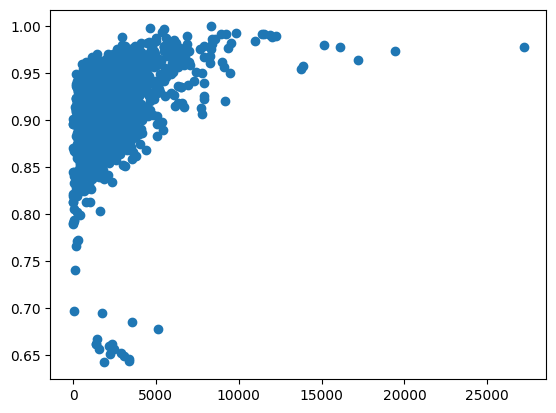

Measure: ('Cognitive disability among adults ages >=18 years',)


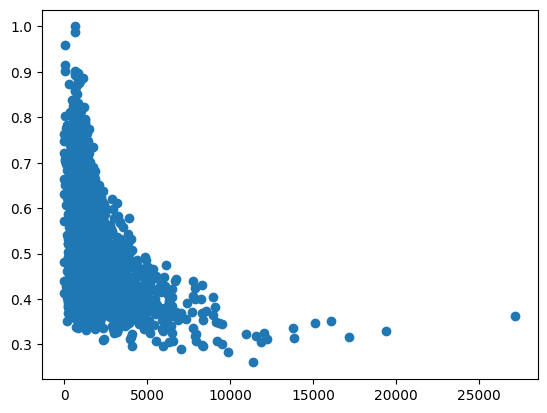

Measure: ('Vision disability among adults aged >=18 years',)


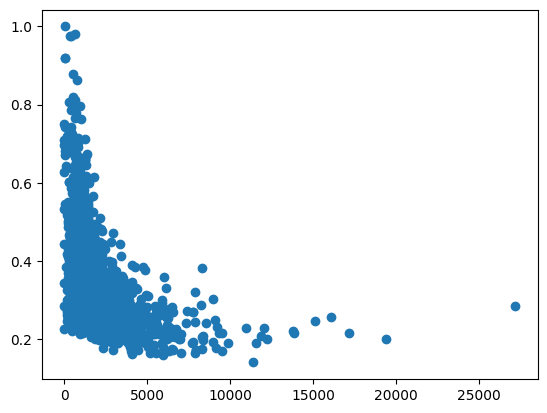

Measure: ('No leisure-time physical activity among adults aged >=18 years',)


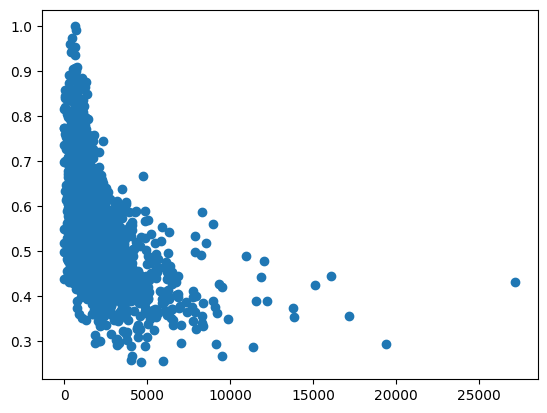

Measure: ('All teeth lost among adults aged >=65 years',)


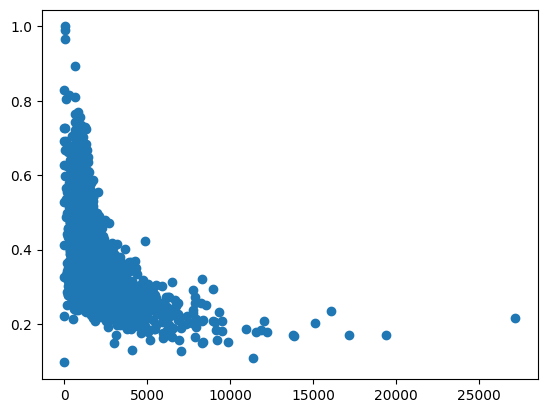

Measure: ('Visits to dentist or dental clinic among adults aged >=18 years',)


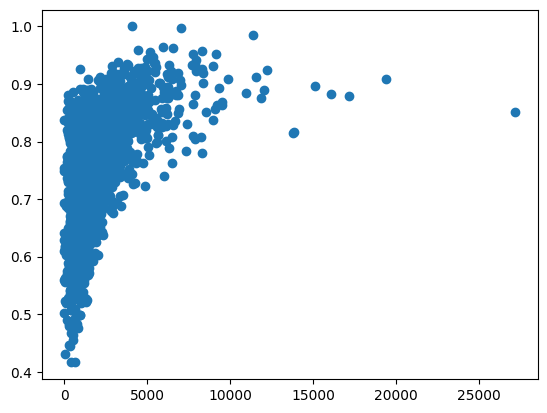

Measure: ('Hearing disability among adults aged >=18 years',)


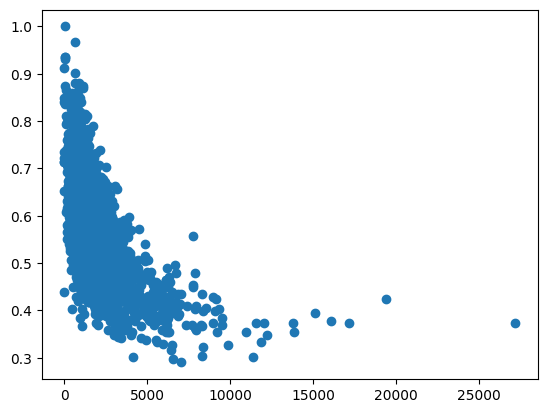

Measure: ('Self-care disability among adults aged >=18 years',)


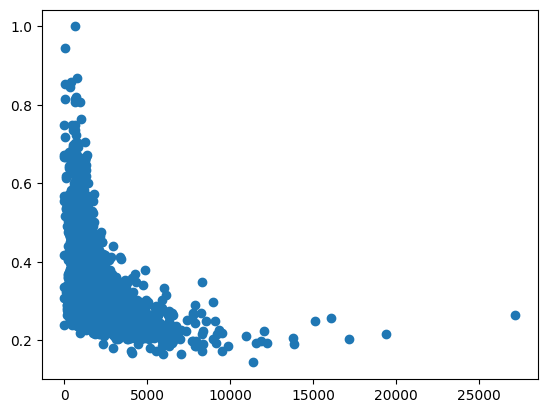

Measure: ('Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure',)


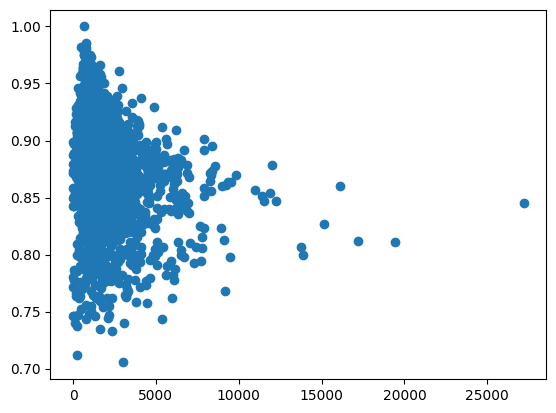

Measure: ('High blood pressure among adults aged >=18 years',)


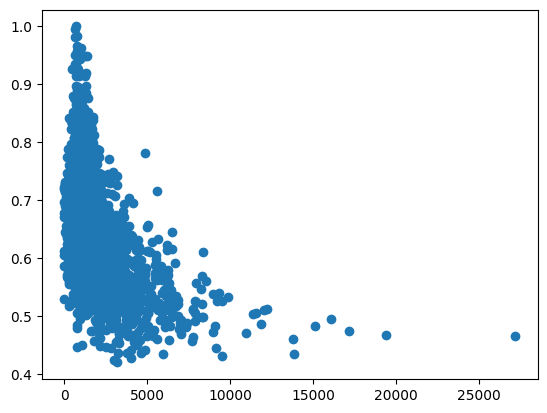

Measure: ('Mammography use among women aged 50-74 years',)


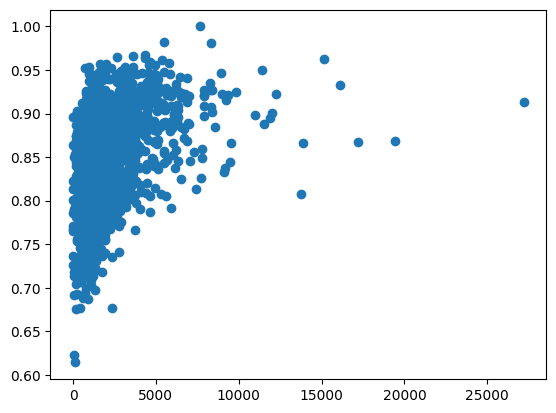

Measure: ('Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',)


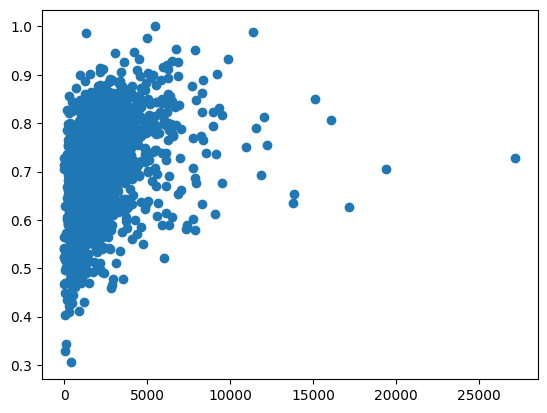

Measure: ('Arthritis among adults aged >=18 years',)


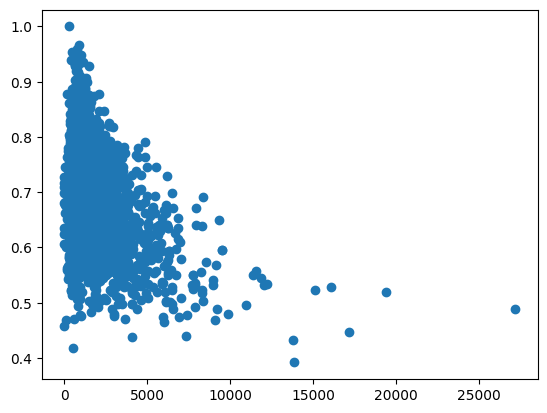

Measure: ('Sleeping less than 7 hours among adults aged >=18 years',)


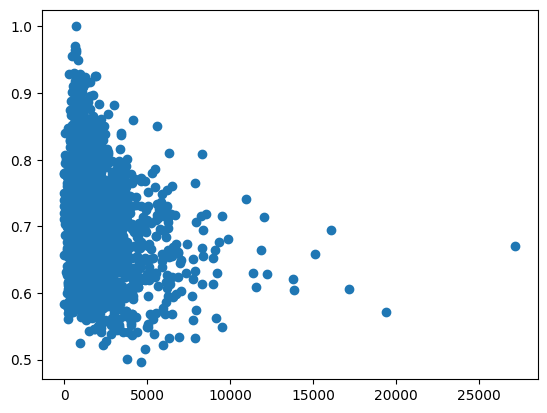

Measure: ('Chronic kidney disease among adults aged >=18 years',)


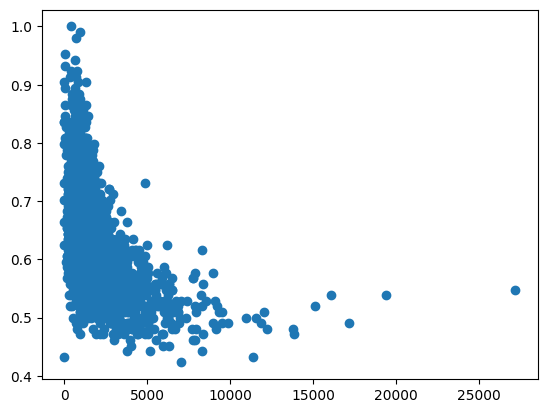

Measure: ('Mobility disability among adults aged >=18 years',)


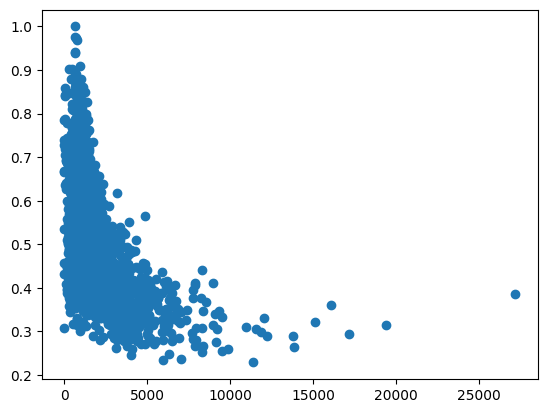

Measure: ('Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',)


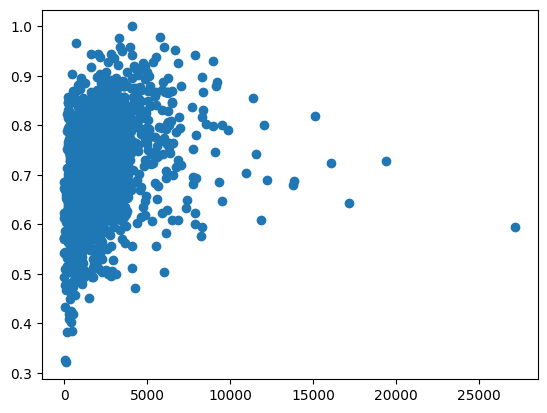

Measure: ('Visits to doctor for routine checkup within the past year among adults aged >=18 years',)


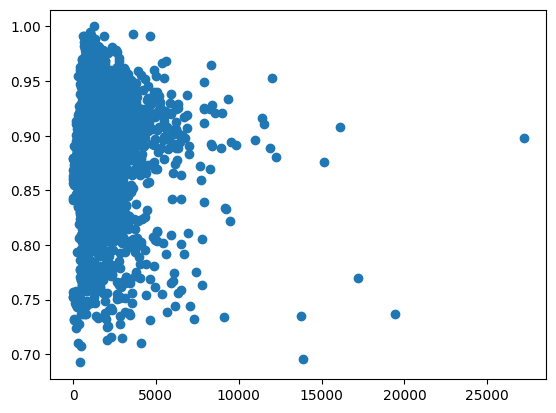

Measure: ('Depression among adults aged >=18 years',)


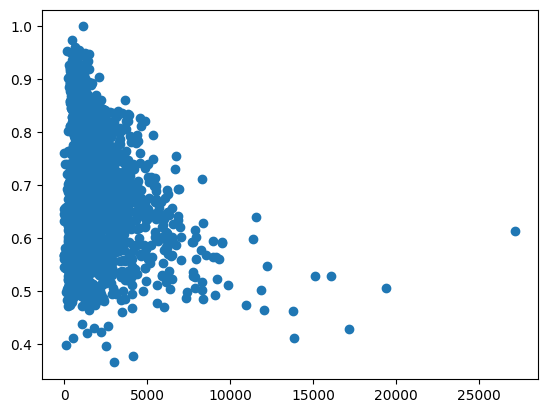

Measure: ('High cholesterol among adults aged >=18 years who have been screened in the past 5 years',)


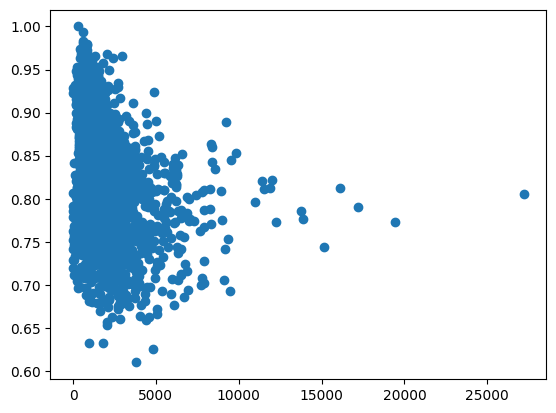

Measure: ('Mental health not good for >=14 days among adults aged >=18 years',)


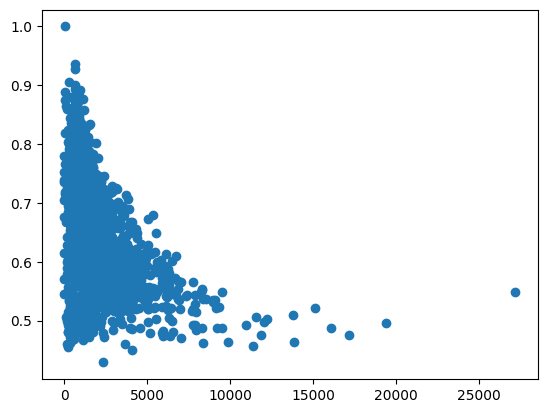

Measure: ('Fair or poor self-rated health status among adults aged >=18 years',)


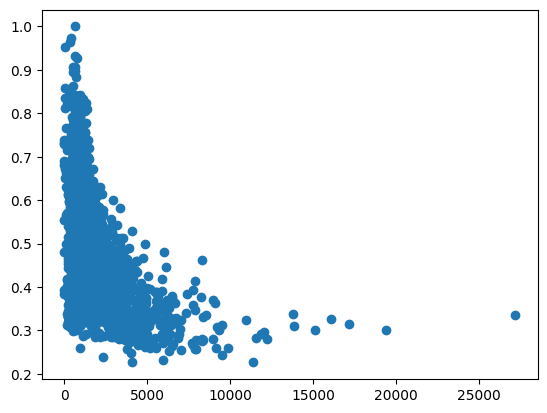

Measure: ('Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',)


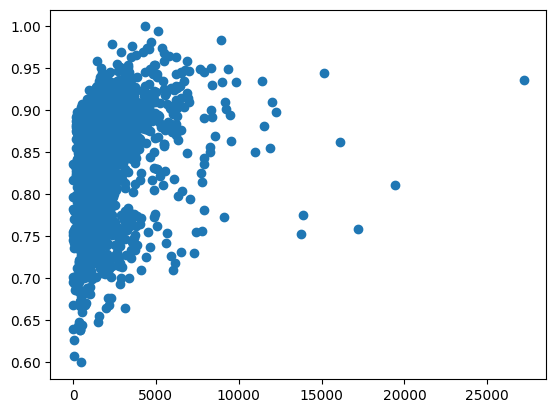

Measure: ('Current asthma among adults aged >=18 years',)


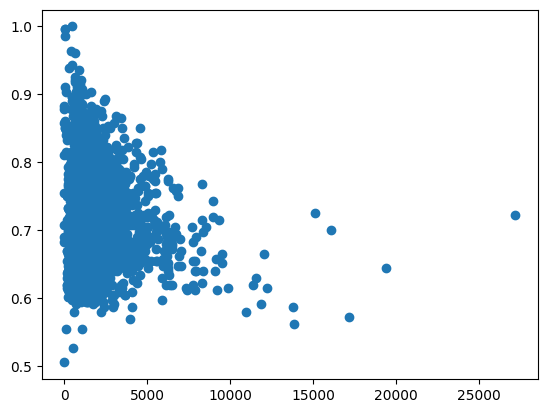

Measure: ('Coronary heart disease among adults aged >=18 years',)


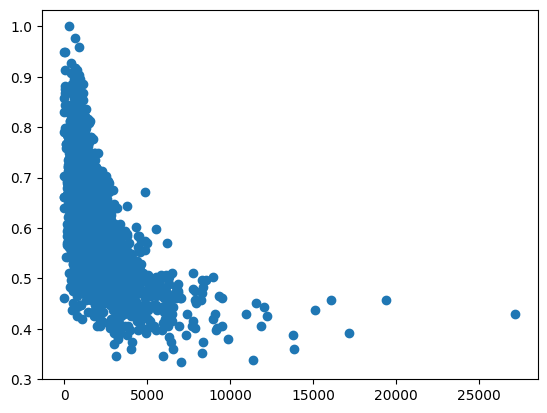

Measure: ('Current smoking among adults aged >=18 years',)


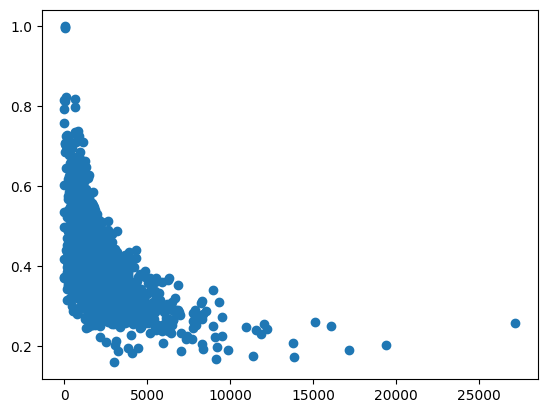

Measure: ('Current lack of health insurance among adults aged 18-64 years',)


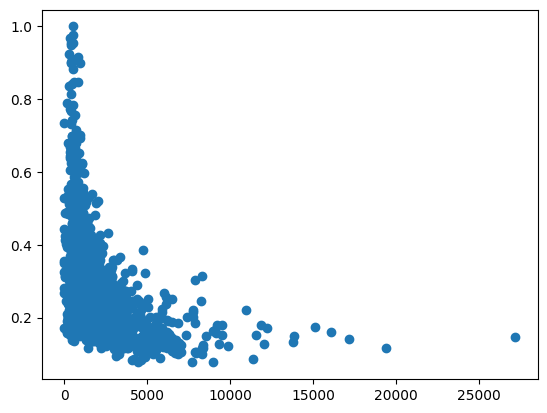

Measure: ('Diagnosed diabetes among adults aged >=18 years',)


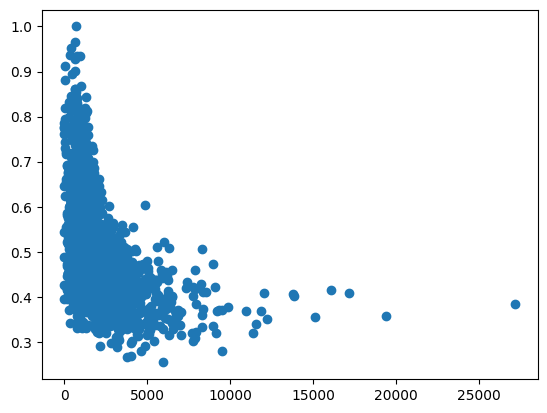

Measure: ('Any disability among adults aged >=18 years',)


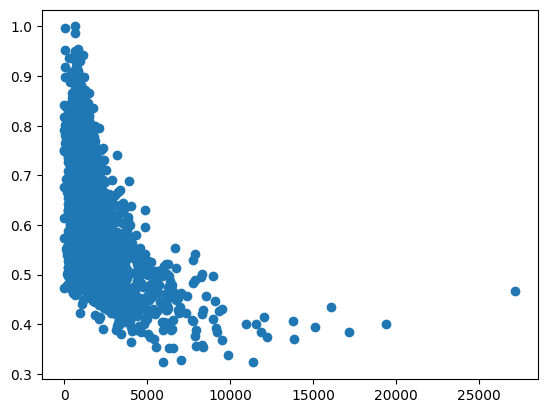

Measure: ('Cervical cancer screening among adult women aged 21-65 years',)


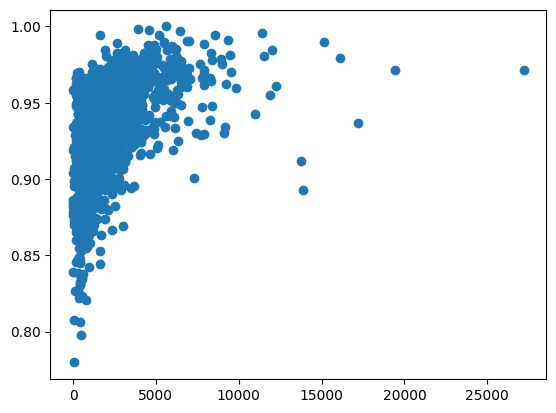

Measure: ('Cancer (excluding skin cancer) among adults aged >=18 years',)


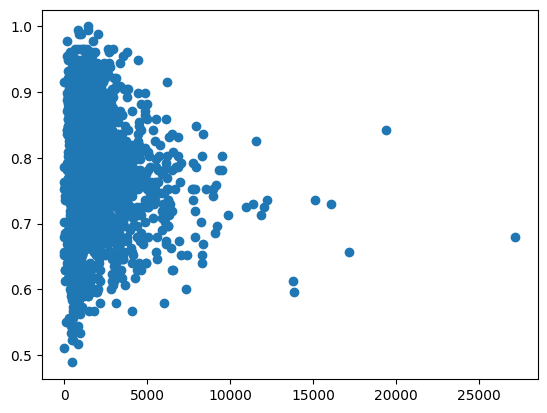

Measure: ('Independent living disability among adults aged >=18 years',)


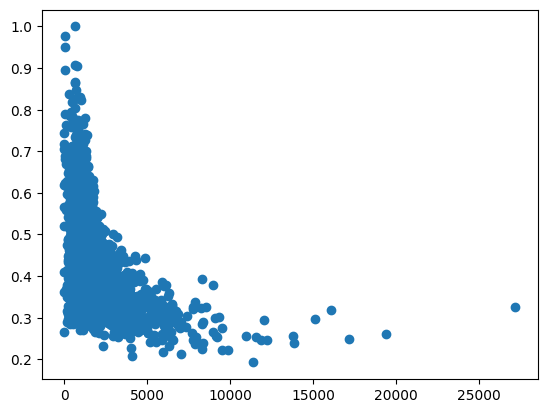

Measure: ('Obesity among adults aged >=18 years',)


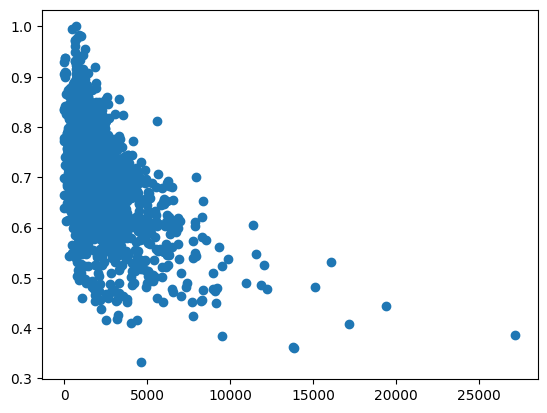

Measure: ('Physical health not good for >=14 days among adults aged >=18 years',)


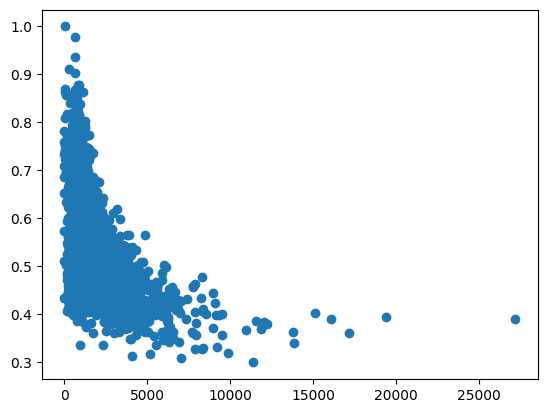

Measure: ('Stroke among adults aged >=18 years',)


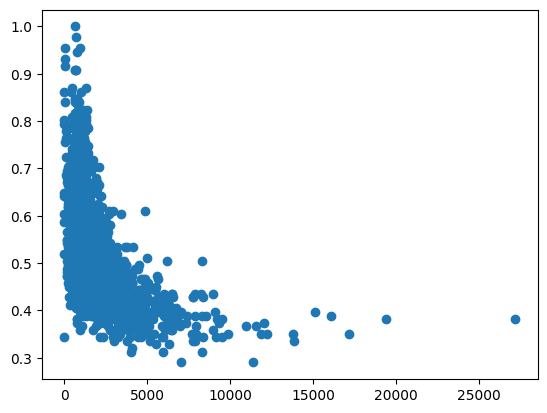

Measure: ('Binge drinking among adults aged >=18 years',)


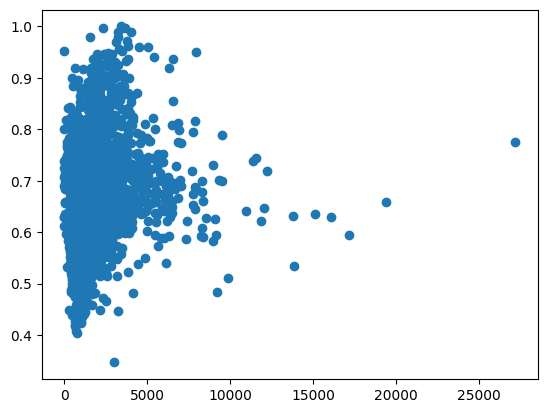

In [457]:
grouped = df.group_by(['MEASURE'])
for (group, frame) in grouped:
    max = frame['avg(DATA_VALUE)'].max()
    mean = frame['avg(DATA_VALUE)'].mean()
    print(f"Measure: {group}")
    
    frame = frame.with_columns( (pl.col('avg(DATA_VALUE)') / max).alias('normalized_dv')) 
    plt.scatter(frame['agiavg'], frame['normalized_dv'])
    plt.show()